In [0]:
import os
import time
import glob

import matplotlib.pyplot as plt
import numpy as np

import PIL

import tensorflow as tf
tf.enable_eager_execution()
from tensorflow.keras import layers
from IPython import display


print(tf.__version__)
print(tf.executing_eagerly())

Generatable_Size = [3840,2160,3]

1.14.0
True


In [0]:
(train_images,train_labels),( _, _) = tf.keras.datasets.mnist.load_data()

In [0]:
train_images = train_images.reshape(train_images.shape[0], 28,28,1).astype('float32')
train_images = (train_images - 127.5)/127.5
print(train_images)

[[[[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  ...

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]]


 [[[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  ...

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]]


 [[[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  ...

  [[-1.]
   [-1.]
   [-1.]
   

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [0]:
TRAIN_DATASET = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

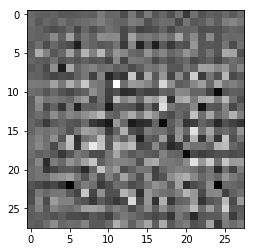

In [0]:
def make_generator_model():
  model = tf.keras.Sequential();
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Reshape((7,7,256)))
  model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding="same",use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding="same",use_bias=False, activation="tanh"))
  return model

sess = tf.Session()

generator = make_generator_model()

noise = tf.random.normal([1, 100], dtype="float32")
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')


In [0]:
def make_discriminator_model(): 
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding="same", input_shape=[28,28,1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))
  model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding="same"))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))
  model.add(layers.Flatten())
  model.add(layers.Dense(1))
  return model

discriminator = make_discriminator_model()

decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00071006]], shape=(1, 1), dtype=float32)


In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def Discriminator_loss(real_output,fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

def Generator_Loss(fake_output):
  return cross_entropy(tf.zeros_like(fake_output),fake_output)

Discriminator_Optimizer = tf.keras.optimizers.Adam()
Generator_Optimizer = tf.keras.optimizers.Adam()





In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=Generator_Optimizer,
                                 discriminator_optimizer=Discriminator_Optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

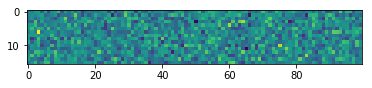

In [0]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
plt.imshow(seed)

In [0]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE,noise_dim])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_image = generator(noise, training=True)
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_image,training=True)

    gen_loss = Generator_Loss(fake_output)
    disc_loss = Discriminator_loss(real_output,fake_output)
  Gradients_Of_Generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  Gradients_Of_Discrimin = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  Generator_Optimizer.apply_gradients(zip(Gradients_Of_Generator, generator.trainable_variables))
  Discriminator_Optimizer.apply_gradients(zip(Gradients_Of_Discrimin,discriminator.trainable_variables))

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    print('Beginning EPOCH ', epoch)
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [0]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

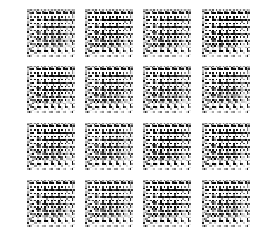

CPU times: user 4min 46s, sys: 1min 14s, total: 6min 1s
Wall time: 20min 36s


In [0]:
%%time
train(TRAIN_DATASET, EPOCHS)